# Overview

This notebook is for Model Prediction Task 1, where I build a predictive algorithm to determine the factors affecting prices of residential properties in Singapore.

In [1]:
# load libraries
import pandas as pd
import numpy as np
from pathlib import Path

import matplotlib.pyplot as plt
import seaborn as sns

import optuna
import xgboost
import shap

import sklearn
sklearn.set_config(transform_output="pandas")

from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder, TargetEncoder
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.compose import ColumnTransformer
from sklearn.metrics import root_mean_squared_error, r2_score

import warnings
warnings.filterwarnings('ignore')

# Data Import
I import and merge the different datasets.

In [2]:
# import dataset

raw_data_folder = Path('../data/HDB')

price_approval_1990_1993 = pd.read_csv(raw_data_folder / 'resale-flat-prices-based-on-approval-date-1990-1999.csv')
price_approval_2000_2012 = pd.read_csv(raw_data_folder / 'resale-flat-prices-based-on-approval-date-2000-feb-2012.csv')
price_reg_2015_2016 = pd.read_csv(raw_data_folder / 'resale-flat-prices-based-on-registration-date-from-jan-2015-to-dec-2016.csv')
price_reg_2017 = pd.read_csv(raw_data_folder / 'resale-flat-prices-based-on-registration-date-from-jan-2017-onwards.csv')
price_reg_2012_2014 = pd.read_csv(raw_data_folder / 'resale-flat-prices-based-on-registration-date-from-mar-2012-to-dec-2014.csv')

I inspect the differences in the dataframes.

In [3]:
display(price_approval_1990_1993.head())
display(price_approval_2000_2012.head())
display(price_reg_2012_2014.head())
display(price_reg_2015_2016.head())
display(price_reg_2017.head())

,month,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,resale_price
0,1990-01,ANG MO KIO,1 ROOM,309,ANG MO KIO AVE 1,10 TO 12,31.0,IMPROVED,1977,9000
1,1990-01,ANG MO KIO,1 ROOM,309,ANG MO KIO AVE 1,04 TO 06,31.0,IMPROVED,1977,6000
2,1990-01,ANG MO KIO,1 ROOM,309,ANG MO KIO AVE 1,10 TO 12,31.0,IMPROVED,1977,8000
3,1990-01,ANG MO KIO,1 ROOM,309,ANG MO KIO AVE 1,07 TO 09,31.0,IMPROVED,1977,6000
4,1990-01,ANG MO KIO,3 ROOM,216,ANG MO KIO AVE 1,04 TO 06,73.0,NEW GENERATION,1976,47200


,month,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,resale_price
0,2000-01,ANG MO KIO,3 ROOM,170,ANG MO KIO AVE 4,07 TO 09,69.0,Improved,1986,147000.0
1,2000-01,ANG MO KIO,3 ROOM,174,ANG MO KIO AVE 4,04 TO 06,61.0,Improved,1986,144000.0
2,2000-01,ANG MO KIO,3 ROOM,216,ANG MO KIO AVE 1,07 TO 09,73.0,New Generation,1976,159000.0
3,2000-01,ANG MO KIO,3 ROOM,215,ANG MO KIO AVE 1,07 TO 09,73.0,New Generation,1976,167000.0
4,2000-01,ANG MO KIO,3 ROOM,218,ANG MO KIO AVE 1,07 TO 09,67.0,New Generation,1976,163000.0


,month,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,resale_price
0,2012-03,ANG MO KIO,2 ROOM,172,ANG MO KIO AVE 4,06 TO 10,45.0,Improved,1986,250000.0
1,2012-03,ANG MO KIO,2 ROOM,510,ANG MO KIO AVE 8,01 TO 05,44.0,Improved,1980,265000.0
2,2012-03,ANG MO KIO,3 ROOM,610,ANG MO KIO AVE 4,06 TO 10,68.0,New Generation,1980,315000.0
3,2012-03,ANG MO KIO,3 ROOM,474,ANG MO KIO AVE 10,01 TO 05,67.0,New Generation,1984,320000.0
4,2012-03,ANG MO KIO,3 ROOM,604,ANG MO KIO AVE 5,06 TO 10,67.0,New Generation,1980,321000.0


,month,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,remaining_lease,resale_price
0,2015-01,ANG MO KIO,3 ROOM,174,ANG MO KIO AVE 4,07 TO 09,60.0,Improved,1986,70,255000.0
1,2015-01,ANG MO KIO,3 ROOM,541,ANG MO KIO AVE 10,01 TO 03,68.0,New Generation,1981,65,275000.0
2,2015-01,ANG MO KIO,3 ROOM,163,ANG MO KIO AVE 4,01 TO 03,69.0,New Generation,1980,64,285000.0
3,2015-01,ANG MO KIO,3 ROOM,446,ANG MO KIO AVE 10,01 TO 03,68.0,New Generation,1979,63,290000.0
4,2015-01,ANG MO KIO,3 ROOM,557,ANG MO KIO AVE 10,07 TO 09,68.0,New Generation,1980,64,290000.0


,month,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,remaining_lease,resale_price
0,2017-01,ANG MO KIO,2 ROOM,406,ANG MO KIO AVE 10,10 TO 12,44.0,Improved,1979,61 years 04 months,232000.0
1,2017-01,ANG MO KIO,3 ROOM,108,ANG MO KIO AVE 4,01 TO 03,67.0,New Generation,1978,60 years 07 months,250000.0
2,2017-01,ANG MO KIO,3 ROOM,602,ANG MO KIO AVE 5,01 TO 03,67.0,New Generation,1980,62 years 05 months,262000.0
3,2017-01,ANG MO KIO,3 ROOM,465,ANG MO KIO AVE 10,04 TO 06,68.0,New Generation,1980,62 years 01 month,265000.0
4,2017-01,ANG MO KIO,3 ROOM,601,ANG MO KIO AVE 5,01 TO 03,67.0,New Generation,1980,62 years 05 months,265000.0


In general, the dataframes share most of their columns. The earlier years are missing remaining lease column, whereas the later years have the remaining lease column but in different format. I will generate the remaining lease column for the earlier year dataframes. I will also regenerate the remaining lease period for the later two dataframes to standardise the method of calculating the lease. 

## Join all dataframes, except for lease column

In [4]:
# Verify that all dataframes have the same column types

# Get reference dataframe column types
reference_df = price_approval_1990_1993
reference_dtypes = reference_df.dtypes
columns_to_join=reference_df.columns

all_consistent = True
dataframes = {
    'price_approval_2000_2012': price_approval_2000_2012,
    'price_reg_2012_2014': price_reg_2012_2014, 
    'price_reg_2015_2016': price_reg_2015_2016,
    'price_reg_2017': price_reg_2017
}

for df_name, df in dataframes.items():
    print(f"Checking {df_name}:")
    
    type_mismatches = []
    for col in columns_to_join:
        if col in df.columns:
            ref_type = reference_dtypes[col]
            curr_type = df[col].dtype
            if ref_type != curr_type:
                type_mismatches.append(f"{col}:{curr_type} instead of {ref_type}")
                all_consistent = False
    
    if type_mismatches:
        for mismatch in type_mismatches:
            print(mismatch)
    else:
        print(f"All column types match reference")

Checking price_approval_2000_2012:
resale_price:float64 instead of int64
Checking price_reg_2012_2014:
resale_price:float64 instead of int64
Checking price_reg_2015_2016:
resale_price:float64 instead of int64
Checking price_reg_2017:
resale_price:float64 instead of int64


Since all the other dataframes are the same, I will align the earliest one.

In [5]:
# Change the column type of resale price in the original dataframe to be consistent with other dataframes
price_approval_1990_1993['resale_price'] = price_approval_1990_1993['resale_price'].astype(float)

In [6]:
# Find columns that are common across all dataframes
all_dataframes = [price_approval_1990_1993] + list(dataframes.values())
common_columns = list(price_approval_1990_1993.columns)

# Concat dataframes together only for columns that are common across all dataframes
combined_df = pd.concat(
    [df[common_columns] for df in all_dataframes],
)

print(f"\nCombined dataframe shape: {combined_df.shape}")
display(combined_df.head())


Combined dataframe shape: (826581, 10)


,month,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,resale_price
0,1990-01,ANG MO KIO,1 ROOM,309,ANG MO KIO AVE 1,10 TO 12,31.0,IMPROVED,1977,9000.0
1,1990-01,ANG MO KIO,1 ROOM,309,ANG MO KIO AVE 1,04 TO 06,31.0,IMPROVED,1977,6000.0
2,1990-01,ANG MO KIO,1 ROOM,309,ANG MO KIO AVE 1,10 TO 12,31.0,IMPROVED,1977,8000.0
3,1990-01,ANG MO KIO,1 ROOM,309,ANG MO KIO AVE 1,07 TO 09,31.0,IMPROVED,1977,6000.0
4,1990-01,ANG MO KIO,3 ROOM,216,ANG MO KIO AVE 1,04 TO 06,73.0,NEW GENERATION,1976,47200.0


In [7]:
combined_df.dtypes

month                      str
town                       str
flat_type                  str
block                      str
street_name                str
storey_range               str
floor_area_sqm         float64
flat_model                 str
lease_commence_date      int64
resale_price           float64
dtype: object

# Data Cleaning

In [8]:
# Check for NaN values in combined dataframe
combined_df.isna().sum()

month                  0
town                   0
flat_type              0
block                  0
street_name            0
storey_range           0
floor_area_sqm         0
flat_model             0
lease_commence_date    0
resale_price           0
dtype: int64

In [9]:
# change all string to upper case
for col in combined_df.select_dtypes(include=['object']).columns:
    combined_df[col] = combined_df[col].str.upper()

combined_df

,month,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,resale_price
0,1990-01,ANG MO KIO,1 ROOM,309,ANG MO KIO AVE 1,10 TO 12,31.0,IMPROVED,1977,9000.0
1,1990-01,ANG MO KIO,1 ROOM,309,ANG MO KIO AVE 1,04 TO 06,31.0,IMPROVED,1977,6000.0
2,1990-01,ANG MO KIO,1 ROOM,309,ANG MO KIO AVE 1,10 TO 12,31.0,IMPROVED,1977,8000.0
3,1990-01,ANG MO KIO,1 ROOM,309,ANG MO KIO AVE 1,07 TO 09,31.0,IMPROVED,1977,6000.0
4,1990-01,ANG MO KIO,3 ROOM,216,ANG MO KIO AVE 1,04 TO 06,73.0,NEW GENERATION,1976,47200.0
...,...,...,...,...,...,...,...,...,...,...
80369,2020-09,YISHUN,5 ROOM,716,YISHUN ST 71,07 TO 09,131.0,IMPROVED,1987,440000.0
80370,2020-09,YISHUN,5 ROOM,760,YISHUN ST 72,07 TO 09,122.0,IMPROVED,1987,458000.0
80371,2020-09,YISHUN,5 ROOM,835,YISHUN ST 81,04 TO 06,122.0,IMPROVED,1987,490000.0
80372,2020-09,YISHUN,EXECUTIVE,791,YISHUN AVE 2,04 TO 06,146.0,MAISONETTE,1987,558000.0


In [10]:
for column in combined_df.select_dtypes(['object']).columns:
    print(f'{column}:{combined_df[column].nunique()}')

month:369
town:27
flat_type:8
block:2454
street_name:568
storey_range:25
flat_model:20


In [11]:
# inspect unique values for town, flat_type, storey_range, flat_model
columns_to_inspect = ['town', 'flat_type', 'storey_range', 'flat_model']
for column in columns_to_inspect:
    unique_values = combined_df[column].unique()
    print(f'Unique values in {column}:')
    print(unique_values)
    print('---')

Unique values in town:
<StringArray>
[     'ANG MO KIO',           'BEDOK',          'BISHAN',     'BUKIT BATOK',
     'BUKIT MERAH',     'BUKIT TIMAH',    'CENTRAL AREA',   'CHOA CHU KANG',
        'CLEMENTI',         'GEYLANG',         'HOUGANG',     'JURONG EAST',
     'JURONG WEST', 'KALLANG/WHAMPOA',   'MARINE PARADE',      'QUEENSTOWN',
        'SENGKANG',       'SERANGOON',        'TAMPINES',       'TOA PAYOH',
       'WOODLANDS',          'YISHUN',    'LIM CHU KANG',       'SEMBAWANG',
   'BUKIT PANJANG',       'PASIR RIS',         'PUNGGOL']
Length: 27, dtype: str
---
Unique values in flat_type:
<StringArray>
[          '1 ROOM',           '3 ROOM',           '4 ROOM',
           '5 ROOM',           '2 ROOM',        'EXECUTIVE',
 'MULTI GENERATION', 'MULTI-GENERATION']
Length: 8, dtype: str
---
Unique values in storey_range:
<StringArray>
['10 TO 12', '04 TO 06', '07 TO 09', '01 TO 03', '13 TO 15', '19 TO 21',
 '16 TO 18', '25 TO 27', '22 TO 24', '28 TO 30', '31 TO 33', '40 TO

Changing everything to uppercase has reduced much of the differences to a smaller range of values that can be encoded later for modelling. I notice that for flat_type, there are two unique values that likely mean the same thing, multi-generation and multi generation, so I remove the dash to standardise the naming.

In [12]:
combined_df['flat_type'] = np.where(combined_df['flat_type'] == 'MULTI-GENERATION', 'MULTI GENERATION', combined_df['flat_type'])

In [13]:
combined_df

,month,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,resale_price
0,1990-01,ANG MO KIO,1 ROOM,309,ANG MO KIO AVE 1,10 TO 12,31.0,IMPROVED,1977,9000.0
1,1990-01,ANG MO KIO,1 ROOM,309,ANG MO KIO AVE 1,04 TO 06,31.0,IMPROVED,1977,6000.0
2,1990-01,ANG MO KIO,1 ROOM,309,ANG MO KIO AVE 1,10 TO 12,31.0,IMPROVED,1977,8000.0
3,1990-01,ANG MO KIO,1 ROOM,309,ANG MO KIO AVE 1,07 TO 09,31.0,IMPROVED,1977,6000.0
4,1990-01,ANG MO KIO,3 ROOM,216,ANG MO KIO AVE 1,04 TO 06,73.0,NEW GENERATION,1976,47200.0
...,...,...,...,...,...,...,...,...,...,...
80369,2020-09,YISHUN,5 ROOM,716,YISHUN ST 71,07 TO 09,131.0,IMPROVED,1987,440000.0
80370,2020-09,YISHUN,5 ROOM,760,YISHUN ST 72,07 TO 09,122.0,IMPROVED,1987,458000.0
80371,2020-09,YISHUN,5 ROOM,835,YISHUN ST 81,04 TO 06,122.0,IMPROVED,1987,490000.0
80372,2020-09,YISHUN,EXECUTIVE,791,YISHUN AVE 2,04 TO 06,146.0,MAISONETTE,1987,558000.0


# Feature Engineering

A key limitation of this analysis is that some of the 'month' column refer to approval date while some refer to registration date. However, I cannot know what is the difference in duration between these dates for each datapoint as it is likely to be variable.

Hence, I will be treating all of the dates as the same point of time in relation to the sale.

## Generate remaining_lease column
I will recalculate the remaining lease by substracting the month column from the first month of the lease_commence_date.

Another key assumption made here is that the lease commence date is the first month of the stated year, which is actually not true as seen later. However, I will treat it as such. This is another limitation in the analysis.

In [14]:
# verify unique values in lease commence date
combined_df['lease_commence_date'].unique()

array([1977, 1976, 1978, 1979, 1984, 1980, 1985, 1981, 1982, 1986, 1972,
       1983, 1973, 1969, 1975, 1971, 1974, 1967, 1970, 1968, 1988, 1987,
       1989, 1990, 1992, 1993, 1994, 1991, 1995, 1996, 1997, 1998, 1999,
       2000, 2001, 1966, 2002, 2006, 2003, 2005, 2004, 2008, 2007, 2009,
       2010, 2012, 2011, 2013, 2014, 2015, 2016, 2017, 2018, 2019])

In [15]:
def calculate_remaining_lease(lease_commence_date, resale_date):
    """
    Calculate remaining lease years from lease commencement to resale date.
    
    Args:
        lease_commence_date: Year only (e.g., 1995)
        resale_date: Year-month format (e.g., "2020-01")
    
    Returns:
        Remaining lease in years (float) to 2 decimal places.
    """
    lease_term = 99  # Standard lease term in years
            
    if isinstance(resale_date, str):
        # Handle different formats: "2020-01", "2020-1"
        if '-' in resale_date:
            resale_year, resale_month = resale_date.split('-')
            resale_year = int(resale_year)
            resale_month = int(resale_month)
        else:
            # only year
            resale_year = int(resale_date)
            resale_month = 1  # Assume January
            
    # Calculate elapsed time in years (with month precision)
    elapsed_years = resale_year - lease_commence_date
    elapsed_months = resale_month - 1  # Start from January of commence year
    elapsed_total = elapsed_years + (elapsed_months / 12.0)
    
    # Calculate remaining lease
    remaining_lease = lease_term - elapsed_total
    
    # Safeguard: ensure remaining lease is not negative
    remaining_lease = max(0, remaining_lease)
    
    return round(remaining_lease, 2)

First I run this function on the latest dataframe to make sure that the numbers are about the same. I convert the original remaining lease to the same format for comparison

In [16]:
def convert_lease_format(lease_string):
    """
    Convert remaining lease from "X years Y months" format to decimal years
    
    Args:
        lease_string: String like "61 years 04 months" or "85 years 11 months"
    
    Returns:
        Decimal years (float)
    """
    
    # Parse the string to extract years and months
    lease_string = str(lease_string).lower()
    
    # Extract years
    years = 0
    if 'year' in lease_string:
        years_part = lease_string.split('year')[0].strip()
        years = int(years_part.split()[-1])
    
    # Extract months  
    months = 0
    if 'month' in lease_string:
        months_part = lease_string.split('year')[-1]
        if 'month' in months_part:
            months_part = months_part.split('month')[0].strip()
            months = int(months_part.split()[-1])
    
    # Convert to decimal years
    return round(years + (months / 12.0), 2)

In [17]:
check_function = price_reg_2017.copy()

# Apply conversion to original remaining lease column
if 'remaining_lease' in check_function.columns:
    check_function['remaining_lease_converted'] = check_function['remaining_lease'].apply(convert_lease_format)

check_function['remaining_lease_recalc'] = check_function.apply(
    lambda row: calculate_remaining_lease(row['lease_commence_date'], row['month']),
    axis=1
)

# Show comparison of different lease calculations
comparison_cols = ['lease_commence_date', 'month', 'remaining_lease', 'remaining_lease_converted', 'remaining_lease_recalc']
available_cols = [col for col in comparison_cols if col in check_function.columns]
display(check_function[available_cols].head(10))

,lease_commence_date,month,remaining_lease,remaining_lease_converted,remaining_lease_recalc
0,1979,2017-01,61 years 04 months,61.33,61.0
1,1978,2017-01,60 years 07 months,60.58,60.0
2,1980,2017-01,62 years 05 months,62.42,62.0
3,1980,2017-01,62 years 01 month,62.08,62.0
4,1980,2017-01,62 years 05 months,62.42,62.0
5,1981,2017-01,63 years,63.00,63.0
6,1979,2017-01,61 years 06 months,61.50,61.0
7,1976,2017-01,58 years 04 months,58.33,58.0
8,1979,2017-01,61 years 06 months,61.50,61.0
9,1979,2017-01,61 years 04 months,61.33,61.0


In [18]:
# caculate difference and run basic statistics
if 'remaining_lease_converted' in check_function.columns and 'remaining_lease_recalc' in check_function.columns:
    check_function['lease_difference'] = check_function['remaining_lease_converted'] - check_function['remaining_lease_recalc']
    
    difference_stats = {
        'mean_difference': check_function['lease_difference'].mean(),
        'median_difference': check_function['lease_difference'].median(),
        'std_difference': check_function['lease_difference'].std(),
        'max_difference': check_function['lease_difference'].max(),
        'min_difference': check_function['lease_difference'].min(),
    }
    
    for stat, value in difference_stats.items():
        print(f"{stat}: {value:.4f}")

mean_difference: 0.4673
median_difference: 0.5000
std_difference: 0.2901
max_difference: 1.5000
min_difference: -0.9200


Here, we can see that there is actually quite significant variance in the remaining lease calculation and the actual remaining lease, up to a difference of 1.5 years. However, I will still proceed to use my method of recalculating remaining lease for the combined dataframe, as there is no way to determine the actual original purchase date and the sale date, especially for the older years.

In [19]:
combined_df['remaining_lease_recalc'] = combined_df.apply(
    lambda row: calculate_remaining_lease(row['lease_commence_date'], row['month']),
    axis=1)

combined_df

,month,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,resale_price,remaining_lease_recalc
0,1990-01,ANG MO KIO,1 ROOM,309,ANG MO KIO AVE 1,10 TO 12,31.0,IMPROVED,1977,9000.0,86.00
1,1990-01,ANG MO KIO,1 ROOM,309,ANG MO KIO AVE 1,04 TO 06,31.0,IMPROVED,1977,6000.0,86.00
2,1990-01,ANG MO KIO,1 ROOM,309,ANG MO KIO AVE 1,10 TO 12,31.0,IMPROVED,1977,8000.0,86.00
3,1990-01,ANG MO KIO,1 ROOM,309,ANG MO KIO AVE 1,07 TO 09,31.0,IMPROVED,1977,6000.0,86.00
4,1990-01,ANG MO KIO,3 ROOM,216,ANG MO KIO AVE 1,04 TO 06,73.0,NEW GENERATION,1976,47200.0,85.00
...,...,...,...,...,...,...,...,...,...,...,...
80369,2020-09,YISHUN,5 ROOM,716,YISHUN ST 71,07 TO 09,131.0,IMPROVED,1987,440000.0,65.33
80370,2020-09,YISHUN,5 ROOM,760,YISHUN ST 72,07 TO 09,122.0,IMPROVED,1987,458000.0,65.33
80371,2020-09,YISHUN,5 ROOM,835,YISHUN ST 81,04 TO 06,122.0,IMPROVED,1987,490000.0,65.33
80372,2020-09,YISHUN,EXECUTIVE,791,YISHUN AVE 2,04 TO 06,146.0,MAISONETTE,1987,558000.0,65.33


## sale_year and sale_month
I will also split up the 'month' column, which is actually the sale date, into sale_year and sale_month. This might be a factor that could be related to resale_price, especially if some cooling measures are commonly implemented in certain years or months. There could also be some sort of cyclical effect.

In [20]:
combined_df[['sale_year','sale_month']] = combined_df['month'].str.split('-', expand=True)
combined_df['sale_year'] = combined_df['sale_year'].astype(int)
combined_df['sale_month'] = combined_df['sale_month'].astype(int)
combined_df

,month,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,resale_price,remaining_lease_recalc,sale_year,sale_month
0,1990-01,ANG MO KIO,1 ROOM,309,ANG MO KIO AVE 1,10 TO 12,31.0,IMPROVED,1977,9000.0,86.00,1990,1
1,1990-01,ANG MO KIO,1 ROOM,309,ANG MO KIO AVE 1,04 TO 06,31.0,IMPROVED,1977,6000.0,86.00,1990,1
2,1990-01,ANG MO KIO,1 ROOM,309,ANG MO KIO AVE 1,10 TO 12,31.0,IMPROVED,1977,8000.0,86.00,1990,1
3,1990-01,ANG MO KIO,1 ROOM,309,ANG MO KIO AVE 1,07 TO 09,31.0,IMPROVED,1977,6000.0,86.00,1990,1
4,1990-01,ANG MO KIO,3 ROOM,216,ANG MO KIO AVE 1,04 TO 06,73.0,NEW GENERATION,1976,47200.0,85.00,1990,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
80369,2020-09,YISHUN,5 ROOM,716,YISHUN ST 71,07 TO 09,131.0,IMPROVED,1987,440000.0,65.33,2020,9
80370,2020-09,YISHUN,5 ROOM,760,YISHUN ST 72,07 TO 09,122.0,IMPROVED,1987,458000.0,65.33,2020,9
80371,2020-09,YISHUN,5 ROOM,835,YISHUN ST 81,04 TO 06,122.0,IMPROVED,1987,490000.0,65.33,2020,9
80372,2020-09,YISHUN,EXECUTIVE,791,YISHUN AVE 2,04 TO 06,146.0,MAISONETTE,1987,558000.0,65.33,2020,9


In [21]:
# drop 'month' column
combined_df = combined_df.drop(columns=['month'])

## inspect street_name and block_number

In [22]:
display(combined_df.value_counts('street_name'))
display(combined_df.value_counts('block'))

street_name
YISHUN RING RD        16210
BEDOK RESERVOIR RD    13734
ANG MO KIO AVE 10     12932
ANG MO KIO AVE 3      11381
HOUGANG AVE 8          8638
                      ...  
HOUGANG ST 32            10
OUTRAM HILL               9
MARINE PARADE CTRL        2
TAMPINES ST 86            2
SUMANG WALK               2
Name: count, Length: 568, dtype: int64

block
2       4309
1       3776
110     3181
101     3154
4       3094
        ... 
256D       1
530B       1
473A       1
294A       1
164A       1
Name: count, Length: 2454, dtype: int64

There are 2454 unique block numbers, and these are unlikely to really contribute to sale price on their own.

In [23]:
temp =combined_df.copy()

temp['address'] = temp['block'].astype(str) + ' ' + temp['street_name'].astype(str)
display(temp.value_counts('address'))

address
211 BOON LAY PL          791
185 BOON LAY AVE         734
208 BOON LAY PL          731
186 BOON LAY AVE         721
210 BOON LAY PL          716
                        ... 
8A UPP BOON KENG RD        1
530B PASIR RIS DR 1        1
473A FERNVALE ST           1
294A COMPASSVALE CRES      1
164A RIVERVALE CRES        1
Name: count, Length: 9279, dtype: int64

The large number of combinations make this difficult to use as a feature, especially when many of them only turn up once.

# Export data for Link Analysis Task II
Here I export the datafile to be used for Link Analysis, which is only considering data form 2015 onwards.

In [24]:
combined_df_filtered = combined_df[combined_df['sale_year']>=2017]
combined_df_filtered

,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,resale_price,remaining_lease_recalc,sale_year,sale_month
0,ANG MO KIO,2 ROOM,406,ANG MO KIO AVE 10,10 TO 12,44.0,IMPROVED,1979,232000.0,61.00,2017,1
1,ANG MO KIO,3 ROOM,108,ANG MO KIO AVE 4,01 TO 03,67.0,NEW GENERATION,1978,250000.0,60.00,2017,1
2,ANG MO KIO,3 ROOM,602,ANG MO KIO AVE 5,01 TO 03,67.0,NEW GENERATION,1980,262000.0,62.00,2017,1
3,ANG MO KIO,3 ROOM,465,ANG MO KIO AVE 10,04 TO 06,68.0,NEW GENERATION,1980,265000.0,62.00,2017,1
4,ANG MO KIO,3 ROOM,601,ANG MO KIO AVE 5,01 TO 03,67.0,NEW GENERATION,1980,265000.0,62.00,2017,1
...,...,...,...,...,...,...,...,...,...,...,...,...
80369,YISHUN,5 ROOM,716,YISHUN ST 71,07 TO 09,131.0,IMPROVED,1987,440000.0,65.33,2020,9
80370,YISHUN,5 ROOM,760,YISHUN ST 72,07 TO 09,122.0,IMPROVED,1987,458000.0,65.33,2020,9
80371,YISHUN,5 ROOM,835,YISHUN ST 81,04 TO 06,122.0,IMPROVED,1987,490000.0,65.33,2020,9
80372,YISHUN,EXECUTIVE,791,YISHUN AVE 2,04 TO 06,146.0,MAISONETTE,1987,558000.0,65.33,2020,9


In [25]:
combined_df_filtered.to_csv(raw_data_folder / 'combined_hdb_resale_data.csv', index=False)

# EDA

## Categorical columns
I plot box and whisker plot for categorical columns agaisnt sale price.

In [26]:
columns_to_plot = ['town', 'flat_type', 'storey_range', 'flat_model', 'sale_year', 'sale_month', 'lease_commence_date']

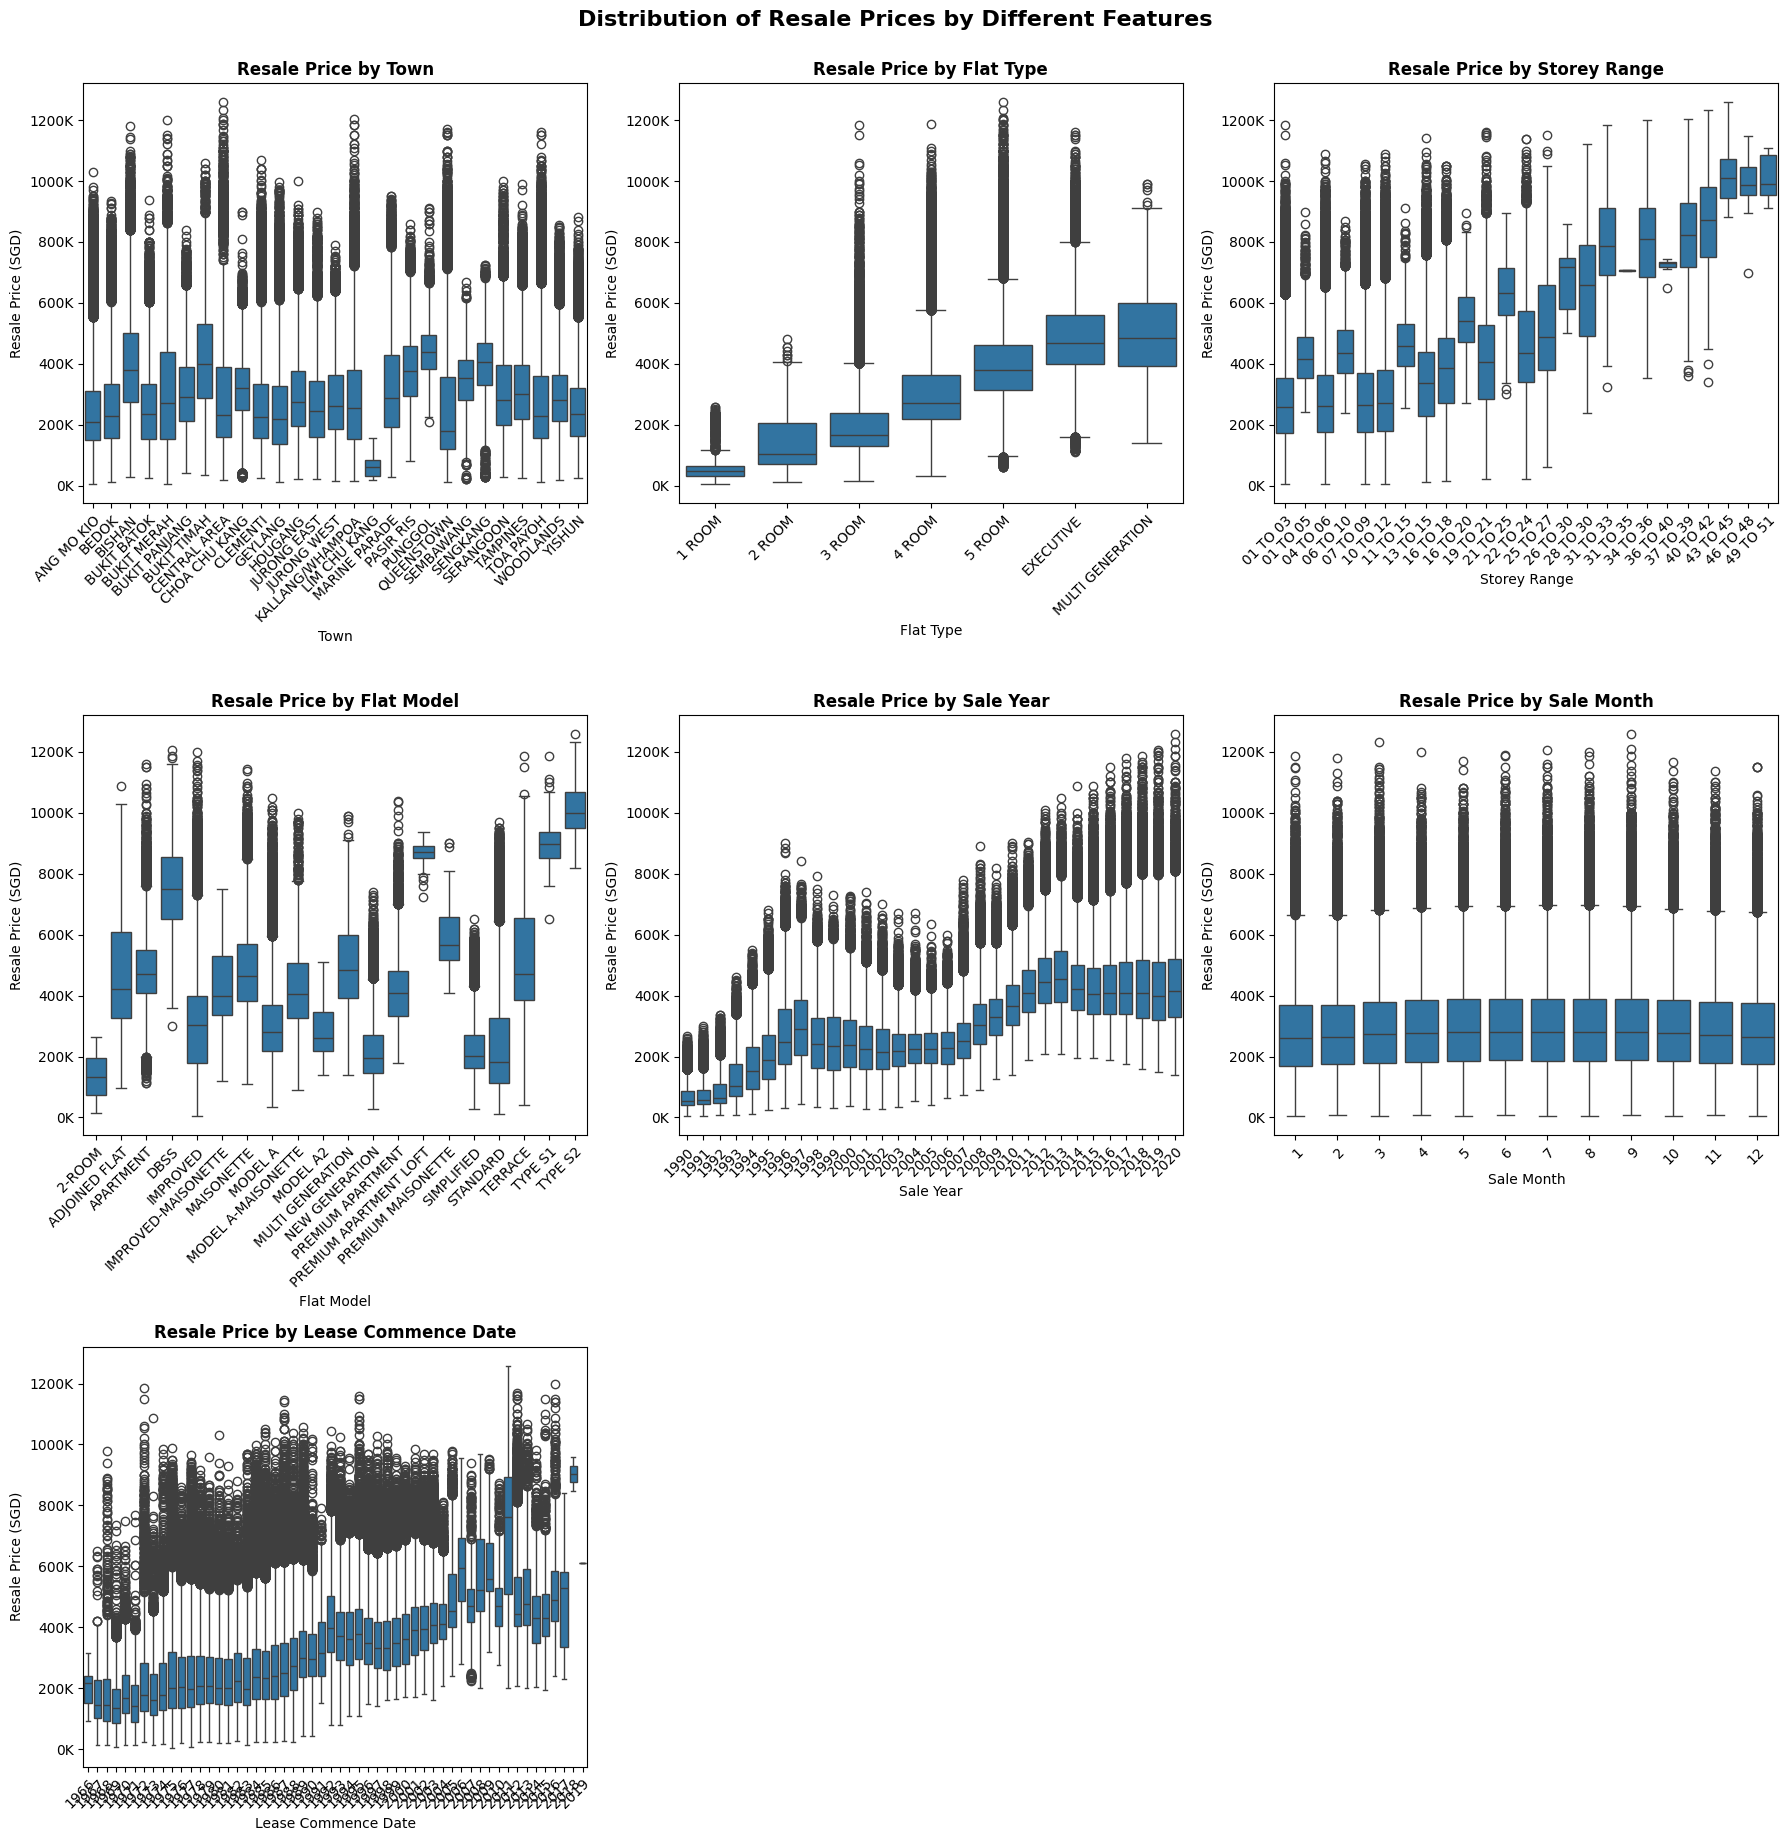

In [27]:
# Set up the subplot layout
n_cols = 3
n_rows = 3
fig, axes = plt.subplots(n_rows, n_cols, figsize=(6*n_cols, 6*n_rows))
axes = axes.flatten()  # Flatten for easier indexing

for i, column in enumerate(columns_to_plot):
    if i < len(axes):
        # Sort categories alphabetically for each column
        sorted_categories = sorted(combined_df[column].unique())
        
        sns.boxplot(data=combined_df, x=column, y='resale_price', ax=axes[i], order=sorted_categories)
        
        axes[i].set_title(f'Resale Price by {column.replace("_", " ").title()}', fontsize=12, fontweight='bold')
        axes[i].set_xlabel(column.replace("_", " ").title(), fontsize=10)
        axes[i].set_ylabel('Resale Price (SGD)', fontsize=10)

        axes[i].tick_params(axis='x', rotation=45)
        for label in axes[i].get_xticklabels():
            label.set_horizontalalignment('right')
            label.set_rotation_mode('anchor')

        # Format y-axis to show prices in thousands
        axes[i].yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x/1000:.0f}K'))
    
# Hide any unused subplots
for i in range(len(columns_to_plot), len(axes)):
    axes[i].set_visible(False)

# Adjust layout to prevent overlap
plt.tight_layout()
plt.suptitle('Distribution of Resale Prices by Different Features', fontsize=16, fontweight='bold', y=1.02)
plt.show()

There is clearly some relationships between the different categorical features and and resale price, with the clearest being an increasing trend with flat type and storey range. Prices also increase over the years. The smallest impact is sale_month, but there is some minor drift in the median.

## Numerical columns
For numerical columns, I do a scatter plot.

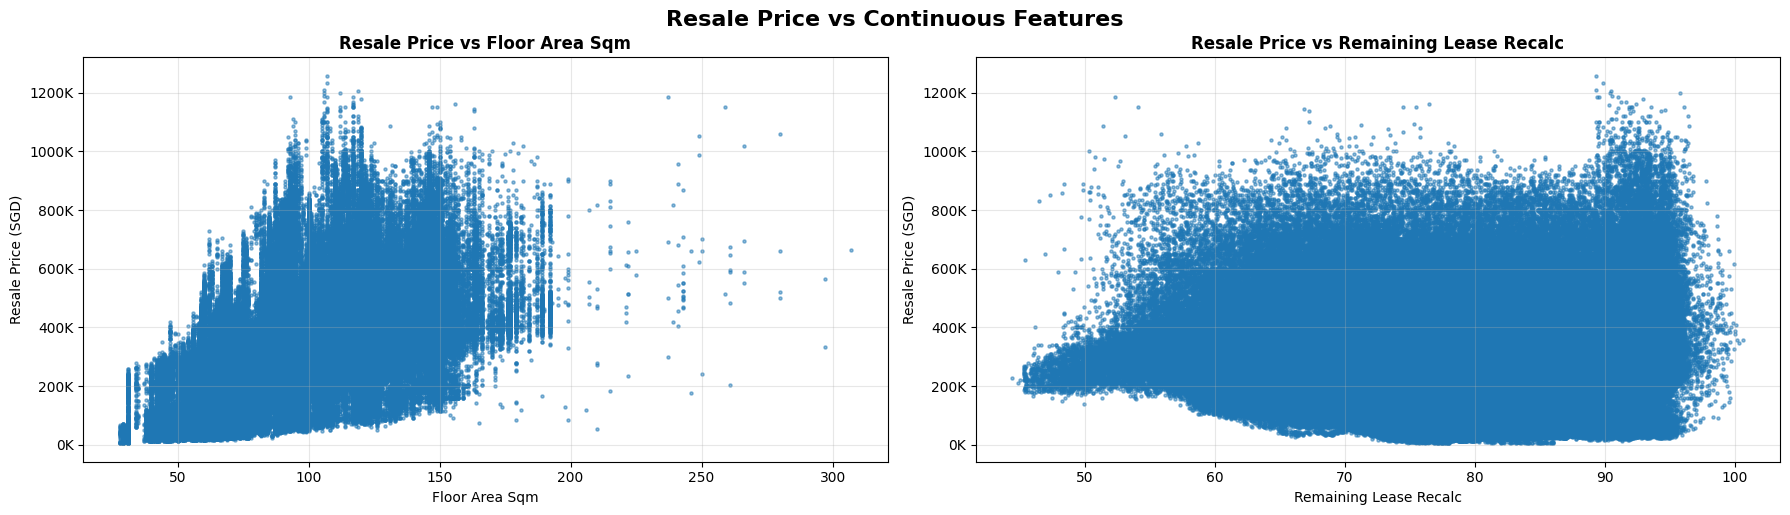

In [28]:
columns_to_scatter = [
    'floor_area_sqm', 
    'remaining_lease_recalc'
    ]

n_cols = 2
n_rows = 1
fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 5))

for i, column in enumerate(columns_to_scatter):
    x_data = combined_df[column]
    
    axes[i].scatter(x_data, combined_df['resale_price'], alpha=0.5, s=5)
    
    axes[i].set_title(f'Resale Price vs {column.replace("_", " ").title()}', fontsize=12, fontweight='bold')
    axes[i].set_xlabel(column.replace("_", " ").title(), fontsize=10)
    axes[i].set_ylabel('Resale Price (SGD)', fontsize=10)
    
    # Format y-axis to show prices in thousands
    axes[i].yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x/1000:.0f}K'))
    
    axes[i].grid(True, alpha=0.3)

# Adjust layout to prevent overlap
plt.tight_layout()
plt.suptitle('Resale Price vs Continuous Features', fontsize=16, fontweight='bold', y=1.02)
plt.show()

There appears to be some upward trend with resale price and floor area sqm, and potentially some trend with resale price and remaining lease, but the latter is less clear, except that resale price decreases a lot when there is little lease remaining, which makes sense.

# Model Training with Optuna Hyperparameter Tuning

A predictive model for housing prices needs to predict prices for future data, so the training set should use data from the older years, and the test set should be newer data.

## Train test split
90-10 split is prepared.

In [29]:
# Ensure chronological order
df = combined_df.sort_values(['sale_year', 'sale_month']).reset_index(drop=True)

# Define split points
test_idx = int(len(df) * 0.90)
X_train = df.iloc[:test_idx].copy().drop(columns=['resale_price'])
y_train = df.iloc[:test_idx]['resale_price']

X_test = df.iloc[test_idx:].copy().drop(columns=['resale_price'])
y_test = df.iloc[test_idx:]['resale_price']

I also extract the letter after the block number and change the remaining to integer, which allows the model to treat it as a numerical feature.

In [30]:
def clean_block_column(df):
    # 1. Extract the numeric part (e.g., '123A' -> 123)
    df['block_num'] = df['block'].str.extract('(\d+)').astype(int)
    
    # 2. Create a flag for suffixes (e.g., '123A' -> 1, '123' -> 0)
    # This helps the model identify special blocks like annexes or SERS replacements
    df['block_has_letter'] = df['block'].str.contains('[a-zA-Z]').astype(int)
    
    df = df.drop(columns=['block'])

    return df

# Apply to all your sets
X_train = clean_block_column(X_train)
X_test = clean_block_column(X_test)

In [31]:
X_train

,town,flat_type,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,remaining_lease_recalc,sale_year,sale_month,block_num,block_has_letter
0,ANG MO KIO,1 ROOM,ANG MO KIO AVE 1,10 TO 12,31.0,IMPROVED,1977,86.00,1990,1,309,0
1,ANG MO KIO,1 ROOM,ANG MO KIO AVE 1,04 TO 06,31.0,IMPROVED,1977,86.00,1990,1,309,0
2,ANG MO KIO,1 ROOM,ANG MO KIO AVE 1,10 TO 12,31.0,IMPROVED,1977,86.00,1990,1,309,0
3,ANG MO KIO,1 ROOM,ANG MO KIO AVE 1,07 TO 09,31.0,IMPROVED,1977,86.00,1990,1,309,0
4,ANG MO KIO,3 ROOM,ANG MO KIO AVE 1,04 TO 06,73.0,NEW GENERATION,1976,85.00,1990,1,216,0
...,...,...,...,...,...,...,...,...,...,...,...,...
743917,JURONG EAST,5 ROOM,TEBAN GDNS RD,13 TO 15,121.0,IMPROVED,1986,68.17,2016,11,53,0
743918,JURONG EAST,5 ROOM,JURONG EAST ST 21,07 TO 09,120.0,IMPROVED,1984,66.17,2016,11,227,0
743919,JURONG EAST,5 ROOM,JURONG EAST ST 21,13 TO 15,120.0,IMPROVED,1982,64.17,2016,11,213,0
743920,JURONG EAST,5 ROOM,TOH GUAN RD,01 TO 03,123.0,IMPROVED,1998,80.17,2016,11,286,1


## Encoding

I perform One Hot Encoding on town and flat_model, as there is no clear ordering for these categorical values. For flat_type and storey_range, there is a clear order so I perform ordinal encoding. I perform target_encoding for street_name, as there may be premium streets. However, I only use the train data to encode so there is no data leakage. The TargetEncoder also has default smoothing, and this is performed inside cross validation to minimise risk of data leakage. The encoders are also fitted on train data, and used to transform val and test data (without refitting).

In [32]:
# 1. Define Ordinal Orders
flat_type_order = ['1 ROOM', '2 ROOM', '3 ROOM', '4 ROOM', '5 ROOM', 'EXECUTIVE', 'MULTI GENERATION']
storey_order = sorted(X_train['storey_range'].unique(), key=lambda x: int(x.split(' ')[0]))

# 2. Define Refined Column Groups
# Note: 'block' is dropped from target_enc_cols to reduce noise
numerical_cols = ['floor_area_sqm', 'remaining_lease_recalc', 'block_num']
ordinal_cols = ['flat_type', 'storey_range']
ohe_cols = ['town', 'flat_model']
target_enc_cols = ['street_name'] 
passthrough_cols = ['lease_commence_date', 'sale_year','sale_month', 'block_has_letter']

# 3. Build the Hybrid Preprocessor using sklearn's TargetEncoder
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),
        ('ord', OrdinalEncoder(categories=[flat_type_order, storey_order], 
                               handle_unknown='use_encoded_value', 
                               unknown_value=-1), ordinal_cols),
        ('ohe', OneHotEncoder(handle_unknown='ignore', sparse_output=False), ohe_cols),
        ('target', TargetEncoder(target_type='continuous'), target_enc_cols)
    ],
    remainder='passthrough'
)

In [33]:
X_check = preprocessor.fit_transform(X_train, y_train)
print(X_check.shape)
X_check.columns

(743922, 57)


Index(['num__floor_area_sqm', 'num__remaining_lease_recalc', 'num__block_num',
       'ord__flat_type', 'ord__storey_range', 'ohe__town_ANG MO KIO',
       'ohe__town_BEDOK', 'ohe__town_BISHAN', 'ohe__town_BUKIT BATOK',
       'ohe__town_BUKIT MERAH', 'ohe__town_BUKIT PANJANG',
       'ohe__town_BUKIT TIMAH', 'ohe__town_CENTRAL AREA',
       'ohe__town_CHOA CHU KANG', 'ohe__town_CLEMENTI', 'ohe__town_GEYLANG',
       'ohe__town_HOUGANG', 'ohe__town_JURONG EAST', 'ohe__town_JURONG WEST',
       'ohe__town_KALLANG/WHAMPOA', 'ohe__town_LIM CHU KANG',
       'ohe__town_MARINE PARADE', 'ohe__town_PASIR RIS', 'ohe__town_PUNGGOL',
       'ohe__town_QUEENSTOWN', 'ohe__town_SEMBAWANG', 'ohe__town_SENGKANG',
       'ohe__town_SERANGOON', 'ohe__town_TAMPINES', 'ohe__town_TOA PAYOH',
       'ohe__town_WOODLANDS', 'ohe__town_YISHUN', 'ohe__flat_model_2-ROOM',
       'ohe__flat_model_ADJOINED FLAT', 'ohe__flat_model_APARTMENT',
       'ohe__flat_model_DBSS', 'ohe__flat_model_IMPROVED',
       'ohe__

## Transformation of y to log scale
y is transformed to log_scale because mistakes in lower-priced housing is as important as mistakes in high-priced housing. We want to optimise for the % error in price, rather than raw values.

In [34]:
# Transform target to log scale
y_train_log = np.log1p(y_train)
y_test_log = np.log1p(y_test)

## Run Optimisation
TimeSeriesSplit is used so that selected pipelines are able to generalize on future data. Sample Weights are also calculated to make sure that less frequent flat types are not overlooked.

In [35]:
def objective(trial):
    params = {
        'tree_method': 'hist',
        'device': 'cpu', # ensure use of CPU
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2, log=True),
        'n_estimators': 2000, 
        'subsample': trial.suggest_float('subsample', 0.6, 0.9),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 0.9),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 20),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-2, 10.0, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-2, 10.0, log=True),
    }

    tscv = TimeSeriesSplit(n_splits=5)
    cv_scores = []

    for train_index, val_index in tscv.split(X_train):
        X_tr, X_va = X_train.iloc[train_index], X_train.iloc[val_index]
        y_tr_log, y_va_log = y_train_log.iloc[train_index], y_train_log.iloc[val_index]

        weights_tr = compute_sample_weight(class_weight='balanced', y=X_tr['flat_type'])

        # Process features
        X_tr_proc = preprocessor.fit_transform(X_tr, y_tr_log)
        X_va_proc = preprocessor.transform(X_va)

        model = xgboost.XGBRegressor(**params, early_stopping_rounds=50)
        
        # Fit using sample weights to protect less common flat_types
        model.fit(X_tr_proc, y_tr_log, 
                  sample_weight=weights_tr,
                  eval_set=[(X_va_proc, y_va_log)], 
                  verbose=False)

        # Predict and transform back from log to original scale for RMSE
        preds_log = model.predict(X_va_proc)
        preds = np.expm1(preds_log)
        actuals = np.expm1(y_va_log)
        
        rmse = root_mean_squared_error(actuals, preds)
        cv_scores.append(rmse)

    return np.mean(cv_scores)

In [36]:
# Create and run Optuna study
sampler = optuna.samplers.TPESampler(seed=42, n_startup_trials=10)
TOTAL_TRIALS_GOAL = 50

# 2. Load or create the study
study = optuna.create_study(
    direction='minimize', 
    sampler=sampler, 
    study_name="exp1", 
    storage="sqlite:///study_xgboost.db", 
    load_if_exists=True
)

# 3. Calculate how many are left to run
completed_trials = len(study.trials)
trials_to_run = max(0, TOTAL_TRIALS_GOAL - completed_trials)

if trials_to_run > 0:
    print(f"Study '{study.study_name}' has {completed_trials} trials. Running {trials_to_run} more...")
    study.optimize(objective, n_trials=trials_to_run, show_progress_bar=True)
else:
    print(f"Study already reached the goal of {TOTAL_TRIALS_GOAL} trials.")

[I 2026-02-09 00:21:09,761] Using an existing study with name 'exp1' instead of creating a new one.


Study already reached the goal of 50 trials.


# Train Final Model and Inspect results

In [37]:
study = optuna.load_study(
    study_name="exp1",
    storage="sqlite:///study_xgboost.db"
)

# Get best parameters
best_params = study.best_params
best_rmse = study.best_value

print(f"\nBest RMSE: ${best_rmse:,.2f}")
print(f"Best parameters:")
for param, value in best_params.items():
    if isinstance(value, float):
        print(f"  {param}: {value:.6f}")
    else:
        print(f"  {param}: {value}")


Best RMSE: $53,919.75
Best parameters:
  max_depth: 10
  learning_rate: 0.073850
  subsample: 0.805479
  colsample_bytree: 0.899445
  min_child_weight: 10
  reg_alpha: 0.017525
  reg_lambda: 0.056573


For fitting of final model, I use the final Time Series Split to obtain the validation set, and fit the model on the rest of the training data. This also helps to prevent over fitting.

In [38]:
# Train final model with best parameters on X_train
final_params = best_params.copy()
final_params['random_state'] = 42

tscv = TimeSeriesSplit(n_splits=8) # approximately 10% of original data
# Get the indices for the very last split (the most recent data)
train_index, val_index = list(tscv.split(X_train))[-1]

X_tr, X_va = X_train.iloc[train_index], X_train.iloc[val_index]
y_tr_log, y_va_log = y_train_log.iloc[train_index], y_train_log.iloc[val_index]

# Recalculate weights ONLY for the training portion
weights_tr = compute_sample_weight(class_weight='balanced', y=X_tr['flat_type'])

# Process features separately to avoid leakage 
X_tr_proc = preprocessor.fit_transform(X_tr, y_tr_log)
X_va_proc = preprocessor.transform(X_va)

final_model = xgboost.XGBRegressor(**best_params, n_estimators=5000,early_stopping_rounds=50,)
final_model.fit(
    X_tr_proc, y_tr_log,
    sample_weight=weights_tr,
    eval_set=[(X_va_proc, y_va_log)],
    verbose=False
)

,"objective objective: typing.Union[str, xgboost.sklearn._SklObjWProto, typing.Callable[[typing.Any, typing.Any], typing.Tuple[numpy.ndarray, numpy.ndarray]], NoneType]Specify the learning task and the corresponding learning objective or a customobjective function to be used.For custom objective, see :doc:`/tutorials/custom_metric_obj` and:ref:`custom-obj-metric` for more information, along with the end note forfunction signatures.",'reg:squarederror'
,"base_score base_score: typing.Union[float, typing.List[float], NoneType]The initial prediction score of all instances, global bias.",None
,booster,None
,"callbacks callbacks: typing.Optional[typing.List[xgboost.callback.TrainingCallback]]List of callback functions that are applied at end of each iteration.It is possible to use predefined callbacks by using:ref:`Callback API `... note:: States in callback are not preserved during training, which means callback objects can not be reused for multiple training sessions without reinitialization or deepcopy... code-block:: python for params in parameters_grid: # be sure to (re)initialize the callbacks before each run callbacks = [xgb.callback.LearningRateScheduler(custom_rates)] reg = xgboost.XGBRegressor(**params, callbacks=callbacks) reg.fit(X, y)",None
,colsample_bylevel colsample_bylevel: typing.Optional[float]Subsample ratio of columns for each level.,None
,colsample_bynode colsample_bynode: typing.Optional[float]Subsample ratio of columns for each split.,None
,colsample_bytree colsample_bytree: typing.Optional[float]Subsample ratio of columns when constructing each tree.,0.899445334996735
,"device device: typing.Optional[str].. versionadded:: 2.0.0Device ordinal, available options are `cpu`, `cuda`, and `gpu`.",None
,"early_stopping_rounds early_stopping_rounds: typing.Optional[int].. versionadded:: 1.6.0- Activates early stopping. Validation metric needs to improve at least once in every **early_stopping_rounds** round(s) to continue training. Requires at least one item in **eval_set** in :py:meth:`fit`.- If early stopping occurs, the model will have two additional attributes: :py:attr:`best_score` and :py:attr:`best_iteration`. These are used by the :py:meth:`predict` and :py:meth:`apply` methods to determine the optimal number of trees during inference. If users want to access the full model (including trees built after early stopping), they can specify the `iteration_range` in these inference methods. In addition, other utilities like model plotting can also use the entire model.- If you prefer to discard the trees after `best_iteration`, consider using the callback function :py:class:`xgboost.callback.EarlyStopping`.- If there's more than one item in **eval_set**, the last entry will be used for early stopping. If there's more than one metric in **eval_metric**, the last metric will be used for early stopping.",50
,enable_categorical enable_categorical: boolSee the same parameter of :py:class:`DMatrix` for details.,False
,"eval_metric eval_metric: typing.Union[str, typing.List[typing.Union[str, typing.Callable]], typing.Callable, NoneType].. versionadded:: 1.6.0Metric used for monitoring the training result and early stopping. It can be astring or list of strings as names of predefined metric in XGBoost (See:doc:`/parameter`), one of the metrics in :py:mod:`sklearn.metrics`, or anyother user defined metric that looks like `sklearn.metrics`.If custom objective is also provided, then custom metric should implement thecorresponding reverse link function.Unlike the `scoring` parameter commonly used in scikit-learn, when a callableobject is provided, it's assumed to be a cost function and by default XGBoostwill minimize the result during early stopping.For advanced usage on Early stopping like directly choosing to maximize insteadof minimize, see :py:obj:`xgboost.callback.EarlyStopping`.See :doc:`/tutorials/custom_metric_obj` and :ref:`custom-obj-metric` for moreinformation... code-block:: python from sklearn.datasets import lo

In [39]:
# Evaluate on val and blind test sets
X_test_preprocessed = preprocessor.transform(X_test)

y_va_pred = np.expm1(final_model.predict(X_va_proc))
y_test_pred = np.expm1(final_model.predict(X_test_preprocessed))

val_rmse = root_mean_squared_error(np.expm1(y_va_log), y_va_pred)
val_r2 = r2_score(np.expm1(y_va_log), y_va_pred)

test_rmse = root_mean_squared_error(y_test, y_test_pred)
test_r2 = r2_score(y_test, y_test_pred)

print("\nFinal Model Performance:")
print(f"\nValidation Set:")
print(f"  RMSE: ${val_rmse:,.2f}")
print(f"  R² Score: {val_r2:.4f}")
print(f"\nTest Set (10%, Blind):")
print(f"  RMSE: ${test_rmse:,.2f}")
print(f"  R² Score: {test_r2:.4f}")


Final Model Performance:

Validation Set:
  RMSE: $41,341.15
  R² Score: 0.8980

Test Set (10%, Blind):
  RMSE: $73,040.97
  R² Score: 0.7718


In [40]:
# Create a results dataframe for the test set
results = X_test.copy()
results['actual'] = y_test
results['predicted'] = np.expm1(final_model.predict(X_test_preprocessed))
results['error'] = results['predicted'] - results['actual']
results['abs_error'] = results['error'].abs()

# Calculate RMSE by Town
town_rmse = results.groupby('town').apply(
    lambda x: root_mean_squared_error(x['actual'], x['predicted'])
).sort_values(ascending=False)

# Calculate Mean Absolute Percentage Error (MAPE) by Flat Type
flat_type_mape = results.groupby('flat_type').apply(
    lambda x: (x['abs_error'] / x['actual']).mean() * 100
)

print("Top 5 Towns with Highest Error (RMSE):")
print(town_rmse.head(20))
print("\nAverage Error % by Flat Type:")
print(flat_type_mape)

Top 5 Towns with Highest Error (RMSE):
town
BISHAN             108258.292442
CENTRAL AREA       103577.002335
TOA PAYOH           93475.233110
QUEENSTOWN          92624.761883
CLEMENTI            91930.451463
BUKIT MERAH         84376.665499
ANG MO KIO          83036.524757
KALLANG/WHAMPOA     79297.947703
BUKIT BATOK         79087.704918
CHOA CHU KANG       78930.172469
PUNGGOL             75029.855759
YISHUN              73653.421788
SENGKANG            71133.359776
HOUGANG             68463.400391
JURONG WEST         67813.494984
WOODLANDS           66353.507655
GEYLANG             66271.698708
SEMBAWANG           65680.906526
BEDOK               64769.683307
BUKIT TIMAH         62778.810236
dtype: float64

Average Error % by Flat Type:
flat_type
1 ROOM              29.694286
2 ROOM              18.840528
3 ROOM              21.550069
4 ROOM              15.692440
5 ROOM              13.051940
EXECUTIVE            7.929952
MULTI GENERATION     6.437966
dtype: float64


# Feature Importance

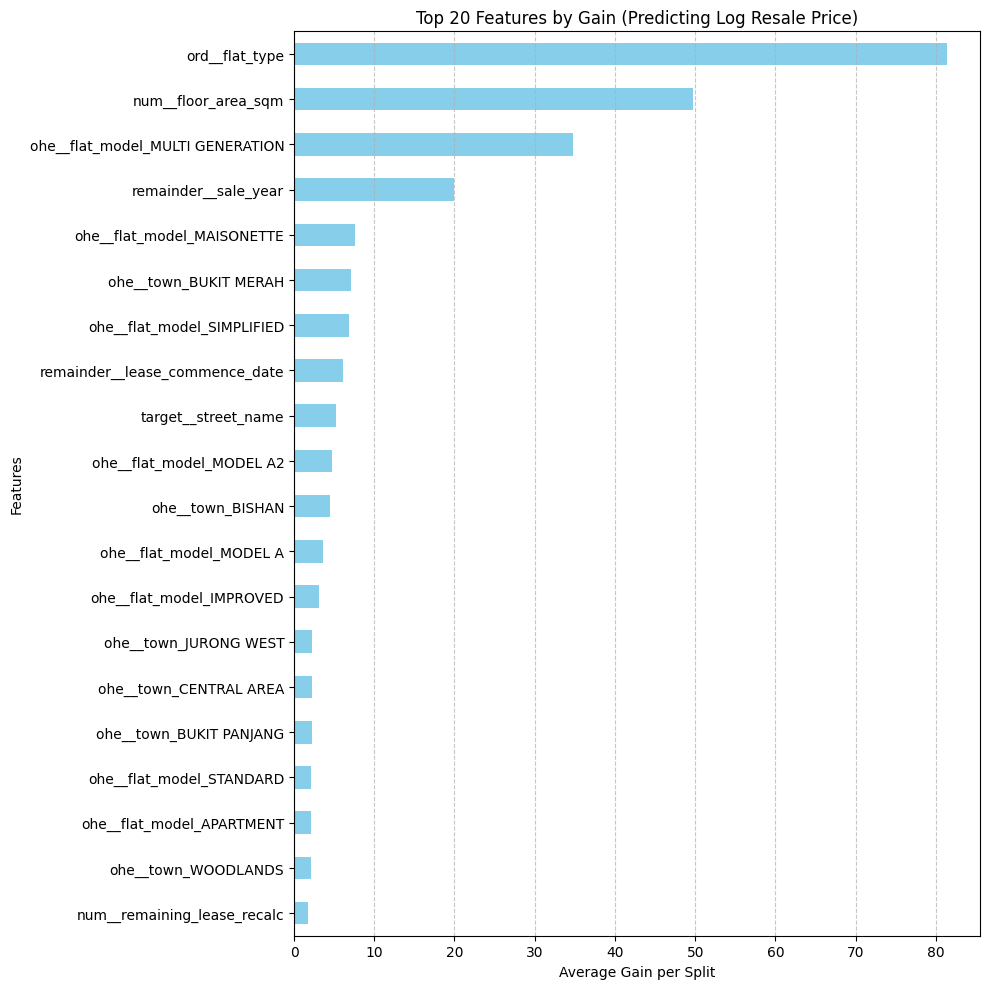

In [41]:
X_check = preprocessor.transform(X_train)
final_model.get_booster().feature_names = X_check.columns.tolist()

# Get the importance (Gain)
importance_dict = final_model.get_booster().get_score(importance_type='gain')

# plotting
importance_df = pd.Series(importance_dict).sort_values(ascending=True)

# 4. Plot the top 20 features
plt.figure(figsize=(10, 10))
importance_df.tail(20).plot(kind='barh', color='skyblue')
plt.xlabel("Average Gain per Split")
plt.ylabel("Features")
plt.title("Top 20 Features by Gain (Predicting Log Resale Price)")
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

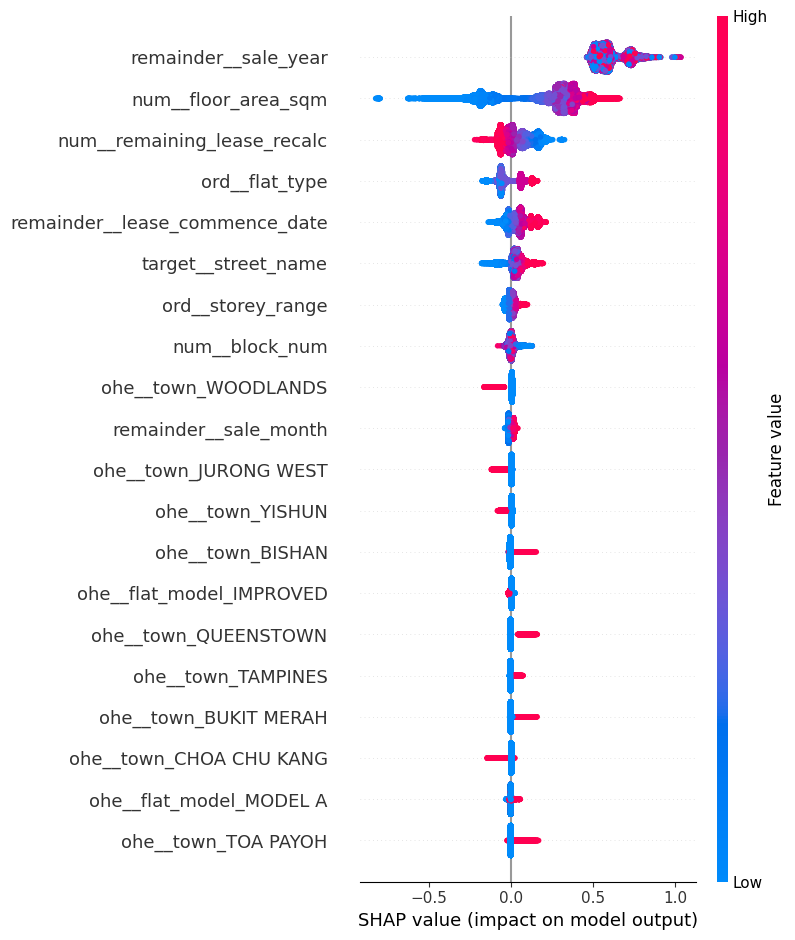

In [42]:
# Explain the model's predictions
explainer = shap.TreeExplainer(final_model)
shap_values = explainer.shap_values(X_test_preprocessed)

# Summary plot
shap.summary_plot(shap_values, X_test_preprocessed)